## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls -l /root/.ssh/

ls: cannot access '/root/.ssh/': No such file or directory


In [3]:
!mkdir -p /root/.ssh/

In [4]:
!ls -l /root/.ssh/

total 0


In [5]:
!cp /content/drive/MyDrive/deploy_keys/id_ed25519* /root/.ssh/

In [6]:
# Add github as trusted entity
!ssh-keyscan github.com >> /root/.ssh/known_hosts

# github.com:22 SSH-2.0-babeld-05989c77
# github.com:22 SSH-2.0-babeld-8405f9f3
# github.com:22 SSH-2.0-babeld-05989c77
# github.com:22 SSH-2.0-babeld-05989c77
# github.com:22 SSH-2.0-babeld-8405f9f3


In [7]:
!ssh -T git@github.com

Hi MysticShadow427/homo-mex-2024! You've successfully authenticated, but GitHub does not provide shell access.


In [8]:
!git clone git@github.com:MysticShadow427/homo-mex-2024.git

Cloning into 'homo-mex-2024'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 19 (delta 2), reused 18 (delta 1), pack-reused 0
Receiving objects: 100% (19/19), 740.34 KiB | 3.70 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [9]:
!ls -l /content

total 12
drwx------ 5 root root 4096 Mar 26 11:50 drive
drwxr-xr-x 5 root root 4096 Mar 26 11:50 homo-mex-2024
drwxr-xr-x 1 root root 4096 Mar 22 13:21 sample_data


In [10]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from transformers import AutoTokenizer

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [11]:
df = pd.read_csv('/content/homo-mex-2024/data/public_data_dev_phase/track_1_dev.csv')
df

,content,label
0,"Me quise ligar a una chava ayer y no me pelo, ...",P
1,"@papaya_rockera eres un puñal, papayita.",P
2,Magnate ofrece 130 mdd al hombre que conquiste...,P
3,Los trolebuses del desgobierno de @EpN son idi...,P
4,"En época de Hitler no se decía ""eres gay"" y, s...",P
...,...,...
6995,(Igual y cachamos a un transformer con este tu...,P
6996,Acabé una temporada de Rupaul's Drag Race en n...,P
6997,@ArielURosas @nuxsilva Ayuññ. pos es que me di...,P
6998,"@LaTortilleriaQ si vamos a hacer un vagón ""seg...",P


In [12]:
df['label'].value_counts()

NP    4360
NR    1778
P      862
Name: label, dtype: int64

In [13]:
class_names = ['P', 'NR', 'NP']

<ipython-input-14-321215fd0db8>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names);


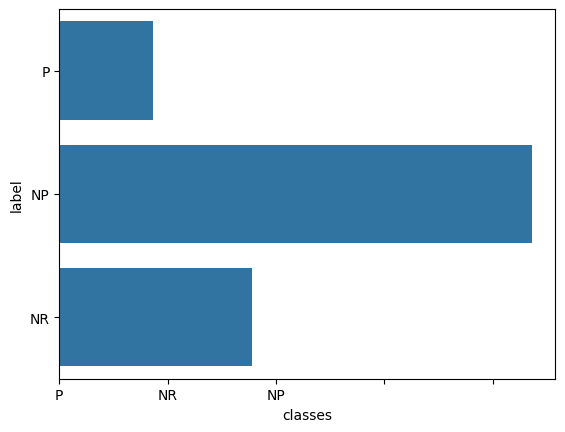

In [14]:
ax = sns.countplot(df.label)
plt.xlabel('classes')
ax.set_xticklabels(class_names);

The balance was (mostly) restored.

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [15]:
df_new = df.copy()

In [16]:
# Function to remove pattern occurrences of '@Username' from a sentence
def remove_pattern(sentence):
    return re.sub(r'@[\w]+', '', sentence)

df_new['content_cleaned'] = df_new['content'].apply(remove_pattern)
df_new = df_new.drop('content',axis = 1)
df_new

,label,content_cleaned
0,P,"Me quise ligar a una chava ayer y no me pelo, ..."
1,P,"eres un puñal, papayita."
2,P,Magnate ofrece 130 mdd al hombre que conquiste...
3,P,Los trolebuses del desgobierno de son idiotas...
4,P,"En época de Hitler no se decía ""eres gay"" y, s..."
...,...,...
6995,P,(Igual y cachamos a un transformer con este tu...
6996,P,Acabé una temporada de Rupaul's Drag Race en n...
6997,P,"Ayuññ. pos es que me dicen: OpH, SEND NERDEZ..."
6998,P,"si vamos a hacer un vagón ""seguro"" que incluy..."


In [17]:
# Function to remove numbers and URLs from a sentence
def remove_numbers_and_urls(sentence):
    # Remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    # Remove URLs
    sentence = re.sub(r'http[s]?://\S+', '', sentence)
    return sentence

df_new['content_cleaned'] = df_new['content_cleaned'].apply(remove_numbers_and_urls)
df_new

,label,content_cleaned
0,P,"Me quise ligar a una chava ayer y no me pelo, ..."
1,P,"eres un puñal, papayita."
2,P,Magnate ofrece mdd al hombre que conquiste a ...
3,P,Los trolebuses del desgobierno de son idiotas...
4,P,"En época de Hitler no se decía ""eres gay"" y, s..."
...,...,...
6995,P,(Igual y cachamos a un transformer con este tu...
6996,P,Acabé una temporada de Rupaul's Drag Race en n...
6997,P,"Ayuññ. pos es que me dicen: OpH, SEND NERDEZ..."
6998,P,"si vamos a hacer un vagón ""seguro"" que incluy..."


In [18]:
# Function to remove characters except specified punctuation marks and spaces
def remove_chars_except_punctuations(sentence):
    # Keep words, '?', '!', ',', '.', and spaces
    sentence = re.sub(r'[^\w\s?!,.]', '', sentence)
    return sentence

# Apply the function to each sentence in the 'text' column
df_new['content_cleaned'] = df_new['content_cleaned'].apply(remove_chars_except_punctuations)
df_new


,label,content_cleaned
0,P,"Me quise ligar a una chava ayer y no me pelo, ..."
1,P,"eres un puñal, papayita."
2,P,Magnate ofrece mdd al hombre que conquiste a ...
3,P,Los trolebuses del desgobierno de son idiotas...
4,P,"En época de Hitler no se decía eres gay y, sí ..."
...,...,...
6995,P,Igual y cachamos a un transformer con este tui...
6996,P,Acabé una temporada de Rupauls Drag Race en na...
6997,P,"Ayuññ. pos es que me dicen OpH, SEND NERDEZ ..."
6998,P,si vamos a hacer un vagón seguro que incluya ...


In [24]:
def remove_newline_pattern(sentence):
    # Remove '\n' pattern
    sentence = re.sub(r'\n', '', sentence)
    return sentence

# Apply the function to each sentence in the 'text' column
df_new['content_cleaned'] = df_new['content_cleaned'].apply(remove_newline_pattern)
df_new

,label,content_cleaned
0,P,"Me quise ligar a una chava ayer y no me pelo, ..."
1,P,"eres un puñal, papayita."
2,P,Magnate ofrece mdd al hombre que conquiste a ...
3,P,Los trolebuses del desgobierno de son idiotas...
4,P,"En época de Hitler no se decía eres gay y, sí ..."
...,...,...
6995,P,Igual y cachamos a un transformer con este tui...
6996,P,Acabé una temporada de Rupauls Drag Race en na...
6997,P,"Ayuññ. pos es que me dicen OpH, SEND NERDEZ ..."
6998,P,si vamos a hacer un vagón seguro que incluya ...


In [19]:
PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-uncased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [20]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

We'll use this text to understand the tokenization process:

In [25]:
sample_txt = df_new.iloc[13]['content_cleaned']
sample_txt

'por que hay puros pUTOS ahí ? por que lloran como señoritas los hombres ? Son puros puñales ?  url'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [26]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: por que hay puros pUTOS ahí ? por que lloran como señoritas los hombres ? Son puros puñales ?  url
   Tokens: ['por', 'que', 'hay', 'puros', 'putos', 'ahí', '?', 'por', 'que', 'llora', '##n', 'como', 'señoritas', 'los', 'hombres', '?', 'son', 'puros', 'puñal', '##es', '?', 'ur', '##l']
Token IDs: [1076, 1041, 1311, 23546, 23076, 1886, 1059, 1076, 1041, 19084, 30959, 1151, 16106, 1067, 2305, 1059, 1318, 23546, 25617, 1018, 1059, 2645, 30962]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [27]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 5)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [28]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 4)

There is also a special token for padding:

In [29]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 1)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [30]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 3)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [34]:
encoding = tokenizer.encode_plus(
  sample_txt,
  truncation = True,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [35]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([    4,  1076,  1041,  1311, 23546, 23076,  1886,  1059,  1076,  1041,
        19084, 30959,  1151, 16106,  1067,  2305,  1059,  1318, 23546, 25617,
         1018,  1059,  2645, 30962,     5,     1,     1,     1,     1,     1,
            1,     1])

The attention mask has the same length:

In [36]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [37]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'por',
 'que',
 'hay',
 'puros',
 'putos',
 'ahí',
 '?',
 'por',
 'que',
 'llora',
 '##n',
 'como',
 'señoritas',
 'los',
 'hombres',
 '?',
 'son',
 'puros',
 'puñal',
 '##es',
 '?',
 'ur',
 '##l',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [38]:
token_lens = []

for txt in df_new.content_cleaned:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

and plot the distribution:

<ipython-input-41-792ad43baa70>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


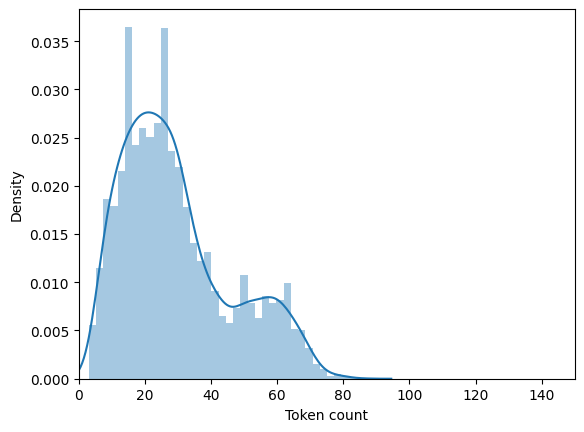

In [41]:
sns.distplot(token_lens)
plt.xlim([0, 150]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [40]:
MAX_LEN = 100

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader

In [43]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      truncation = True,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [44]:
RANDOM_SEED = 42
from sklearn.model_selection import train_test_split

In [57]:
# Label to index
tags = df_new.label.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index
# Encode labels
df_new["label"] = df_new["label"].map(class_to_index)
df_new

,label,content_cleaned
0,0,"Me quise ligar a una chava ayer y no me pelo, ..."
1,0,"eres un puñal, papayita."
2,0,Magnate ofrece mdd al hombre que conquiste a ...
3,0,Los trolebuses del desgobierno de son idiotas...
4,0,"En época de Hitler no se decía eres gay y, sí ..."
...,...,...
6995,0,Igual y cachamos a un transformer con este tui...
6996,0,Acabé una temporada de Rupauls Drag Race en na...
6997,0,"Ayuññ. pos es que me dicen OpH, SEND NERDEZ ..."
6998,0,si vamos a hacer un vagón seguro que incluya ...


In [58]:
df_train, df_test = train_test_split(df_new, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [59]:
df_train.shape, df_val.shape, df_test.shape

((6300, 2), (350, 2), (350, 2))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [60]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df_new.content_cleaned.to_numpy(),
    targets=df_new.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [61]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [62]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [63]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else.

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [82]:
from transformers import AutoModel
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


And try to use it on the encoding of our sample text:

In [74]:
data['input_ids']

tensor([[    4,  1094,  7325,  ...,     1,     1,     1],
        [    4,  1669,  1044,  ...,     1,     1,     1],
        [    4, 21843,  1043,  ...,     1,     1,     1],
        ...,
        [    4,  1076,  1041,  ...,     1,     1,     1],
        [    4,  1085, 21319,  ...,     1,     1,     1],
        [    4,  2404,  3102,  ...,     1,     1,     1]])

In [83]:
last_hidden_state, pooled_output = bert_model(
  input_ids=data['input_ids'],
  attention_mask=data['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [84]:
last_hidden_state.shape

torch.Size([16, 100, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [75]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [85]:
pooled_output.shape

torch.Size([16, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [86]:
import torch.nn as nn

In [88]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [89]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [90]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We'll move the example batch of our training data to the GPU:

In [91]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [93]:
import torch.nn.functional as F


In [95]:
F.softmax(model(input_ids, attention_mask), dim=1).shape

torch.Size([16, 3])

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7330631300571541 accuracy 0.6653729447463129
Val   loss 0.5767546480894089 accuracy 0.7776365946632783

Epoch 2/10
----------
Train loss 0.4158683338330777 accuracy 0.8420012701997036
Val   loss 0.5365073362737894 accuracy 0.832274459974587

Epoch 3/10
----------
Train loss 0.24015077009679367 accuracy 0.922023851527768
Val   loss 0.5074492372572422 accuracy 0.8716645489199493

Epoch 4/10
----------
Train loss 0.16012676668187295 accuracy 0.9546962105708843
Val   loss 0.6009970247745514 accuracy 0.8703939008894537

Epoch 5/10
----------
Train loss 0.11209654617575301 accuracy 0.9675393409074872
Val   loss 0.7367783848941326 accuracy 0.8742058449809403

Epoch 6/10
----------
Train loss 0.08572274737026433 accuracy 0.9764307388328276
Val   loss 0.7251267762482166 accuracy 0.8843710292249047

Epoch 7/10
----------
Train loss 0.06132202987342602 accuracy 0.9833462705525369
Val   loss 0.7083295831084251 accuracy 0.889453621346887

Epoch 8/10
----------
Tra

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

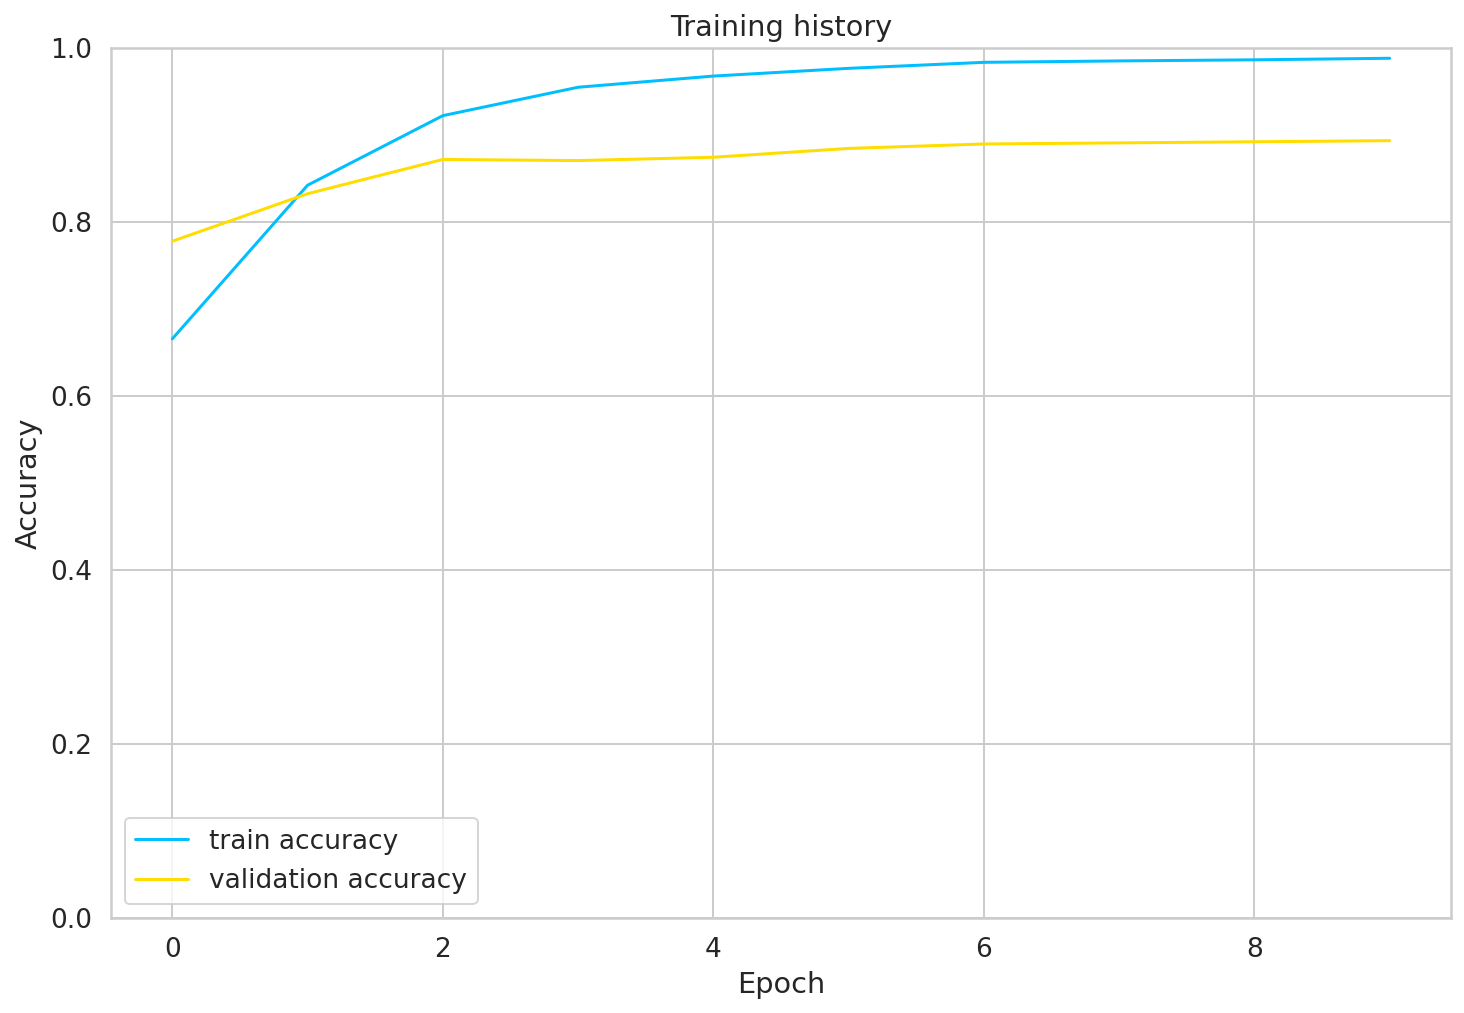

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.883248730964467

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88       245
     neutral       0.83      0.85      0.84       254
    positive       0.92      0.93      0.92       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

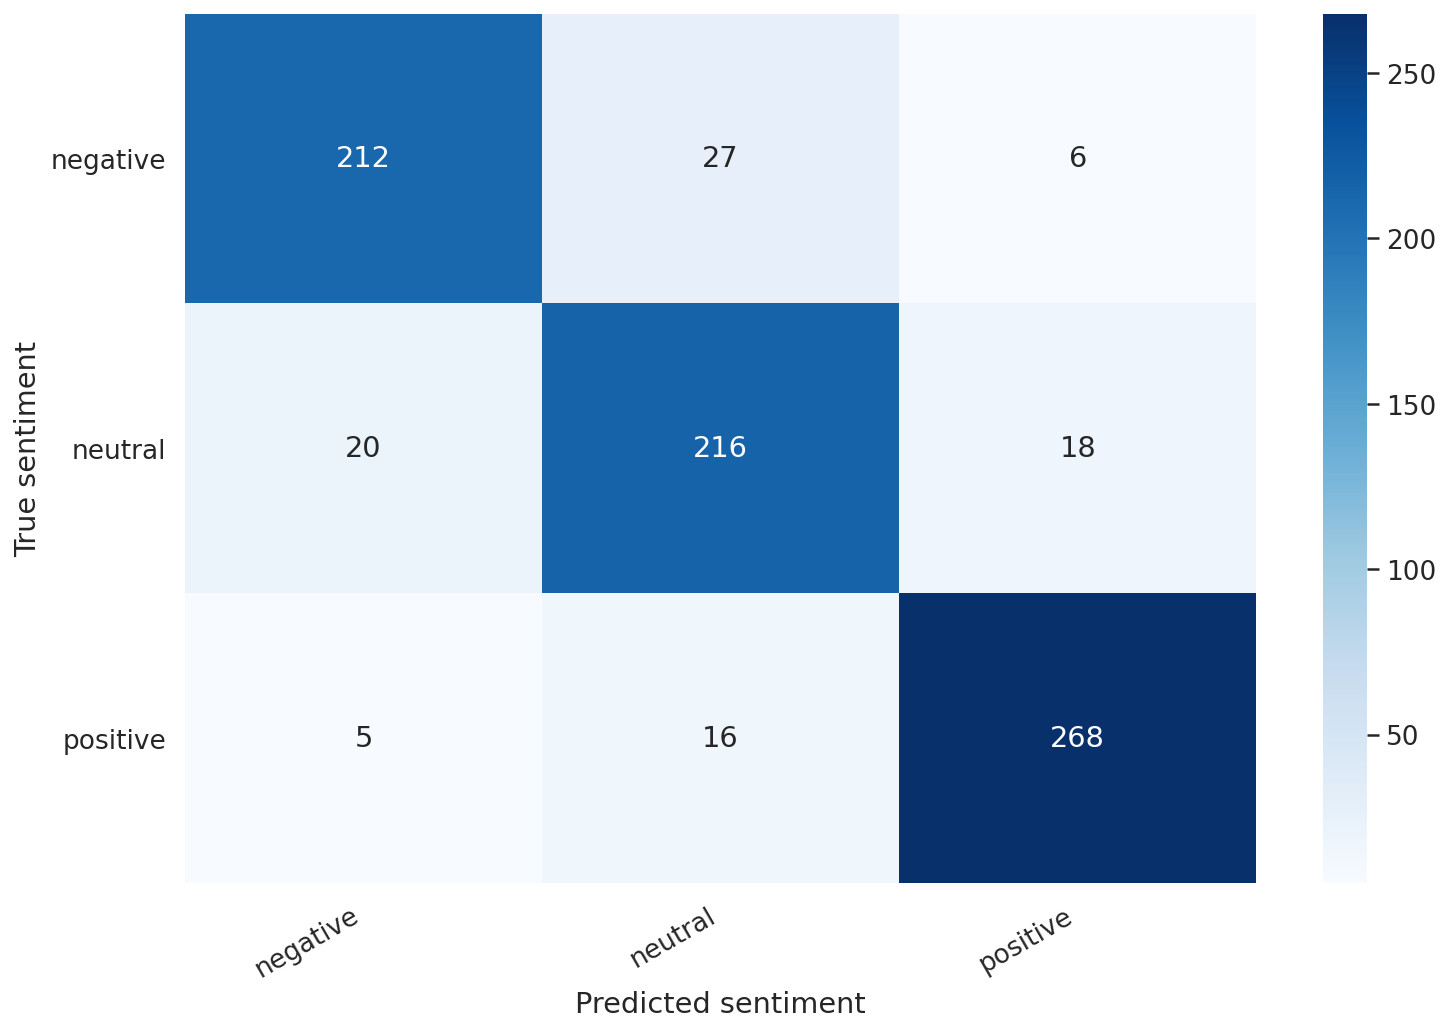

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


Now we can look at the confidence of each sentiment of our model:

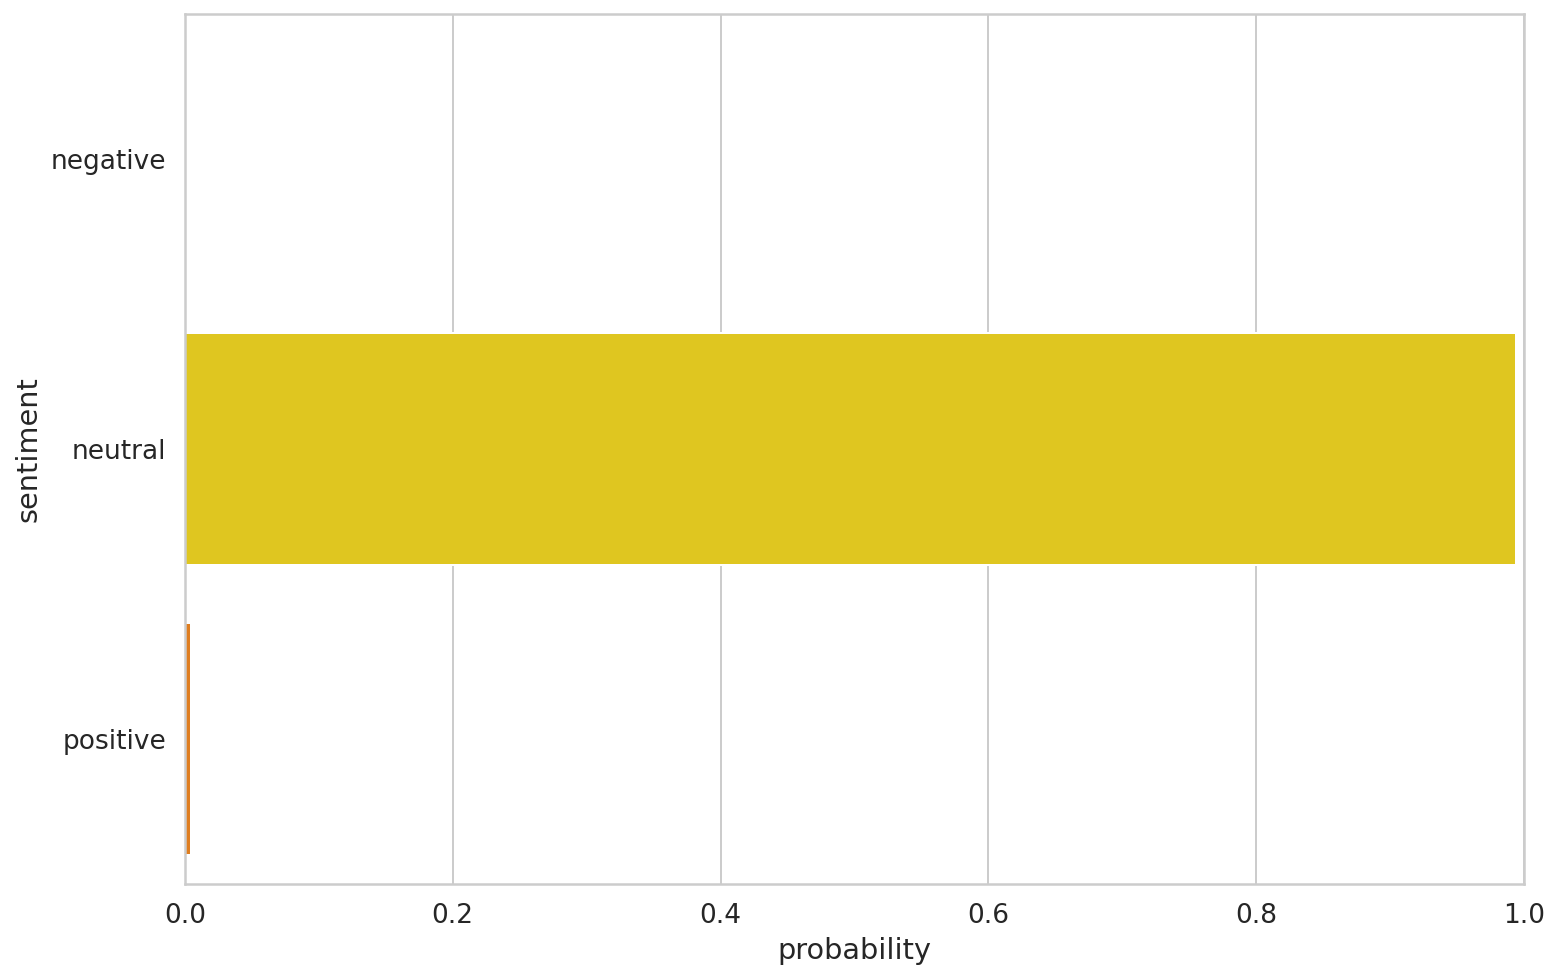

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
